# 1. Download nightlights for Rwanda

- **INPUT**:
 - None
- **OUTPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Single image file giving nightlights intensity around the world

Go to the [DMSP-OLS website](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) and download the satellite nighttime luminosity data (roughly 400MB). We will use the one from 2010. The archive they provide constains several files. Feel free to explore these files. We will only be using the file F182010.v4d_web.stable_lights.avg_vis.tif.


# 2. Download Rwandan DHS and construct cluster-level aggregates

- **INPUT**: 
  - `rwanda_clusters_location.csv`: Coordinates of the centroid of each cluster
- **OUTPUT**: 
  - `rwanda_cluster_avg_asset_2010.csv`: Comma-delimited file indicated average wealth of each cluster 

[Demographic and Health Surveys (DHS)](http://dhsprogram.com/What-We-Do/Survey-Types/DHS.cfm) are nationally-representative household surveys that provide data for a wide range of monitoring and impact evaluation indicators in the areas of population, health, and nutrition. For this, we will need to download the [2010 Rwandan DHS data](http://dhsprogram.com/what-we-do/survey/survey-display-364.cfm). Do not forget to request for the GPS dataset. 


# 3. Test whether night lights data can predict wealth, as observed in DHS

Now that we have "ground truth" measures of average cluster wealth, our goal is to understand whether the nightlights data can be used to predict wealth. First, merge the DHS and nightlights data, and then fit a model of wealth on nightlights.

## 3.1 Merge nightlights and DHS data at cluster level
- **INPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Nightlights data, from Step 1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `DHS_nightlights.csv`: Merged dataset with 492 rows, and 6 columns (one indicates average cluster wealth, 5 nightlights features)
 - Scatterplot of nightlights vs. DHS wealth

Perform a "spatial join" to compute the average nighttime luminosity for each of the DHS clusters. To do this, we should take the average of the luminosity values for the nightlights locations surrounding the cluster centroid.

Save output as `DHS_nightlights.csv` and check that it is the same as the file we have provided.


In [1]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
# import cStringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np


def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)


# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [2]:

raster_file = 'data/nighttime_image/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

In [3]:

# get nightlight features for each cluster
def get_nightlight_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'id': idx, 'max_': max_, 'min_': min_, 'mean_': mean_, 
                      'median_': median_, 'std_': std_, 'wealth': wealth})


clusters = pd.read_csv('processed/rwanda_cluster_avg_asset_2010.csv')
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv('processed/DHS_nightlights.csv', index=None)

(0.0, 50.0)

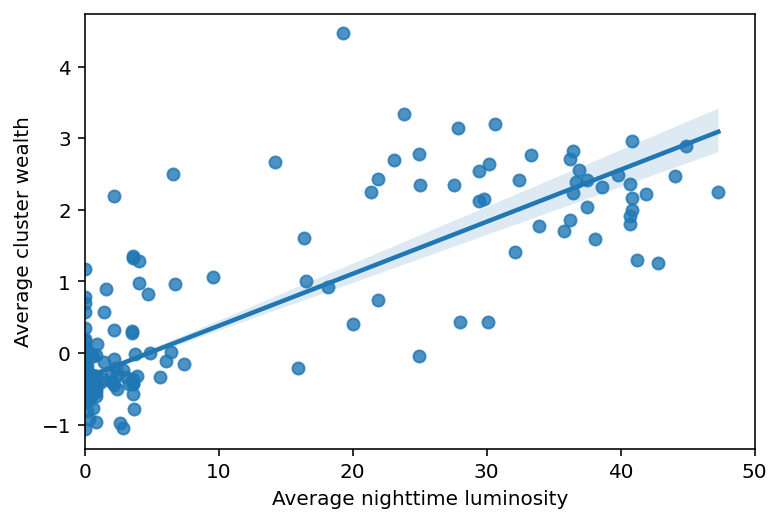

In [4]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, 50])

## 3.2. Fit a model of wealth as a function of nightlights
- **INPUT**: 
 - `DHS_nightlights.csv`, from Step 3.1
- **OUTPUT**: 
 - R^2 of model
 
Above, fit a regression line to illustrate the relationship between cluster average wealth and corresponding cluster nightlights. Now, use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) to get a better sense of out of sample accuracy.


In [5]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = pd.read_csv('processed/DHS_nightlights.csv')
data_all = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].to_numpy()
np.random.seed(42)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f"R^2 of the best model: {np.max(final)}")

R^2 of the best model: 0.7718959066263724


# 4. Download daytime satellite imagery 
- **INPUT**: 
 - Google Maps API key
 - `Sector_Boundary_2012.shp`: Rwandan shapefile
- **OUTPUT**: 
 - Thousands of satellite images (store in directory `google_image/`)

We will use the Google Static Maps API to download satellite images. Refer [Google Static Maps introduction](https://developers.google.com/maps/documentation/static-maps/intro) and [Google Static Maps API Usage Limits](https://developers.google.com/maps/documentation/static-maps/usage-limits). Must apply for an API key before downloading. 

Download the images from Google at zoom level 16 (pixel resolution is about 2.5m). Set the image size to be 400 pixels X 400 pixels, so that each image downloaded will cover 1 square kilometer. In this way, each daytime image downloaded will correspond to a single pixel from the nighttime imagery from Step 1 above.


In [6]:
from retrying import retry
from io import BytesIO
from PIL import Image
from tqdm.auto import tqdm, trange
from dotenv import load_dotenv

load_dotenv()

import os
import requests

KEY = os.getenv('STATIC_MAPS_API_KEY')
SAT_IM_PATH = 'images/latlong'


@retry(wait_exponential_multiplier=1000, wait_exponential_max=3600000)
def save_img(url, file_name):
    
    response = requests.get(url, stream=True)
    b = BytesIO(response.content)
    im = Image.open(b).convert("RGB")
    arr = np.asarray(im)
    # when no image exists, api will return an image with the same color. 
    # and in the center of the image, it said'Sorry. We have no imagery here'.
    # we should drop these images if large area of the image has the same color.
    if np.array_equal(arr[:,:10,:],arr[:,10:20,:]):
        pass
    else:
        width, height = im.size 
        im = im.crop((0, 50, width, 450))
        im.save(os.path.join(SAT_IM_PATH, file_name))



clusters = pd.read_csv('processed/rwanda_cluster_avg_asset_2010.csv')

for lat, long in tqdm(zip(clusters['latitude'].to_list(), clusters['longitude'].to_list())):
    url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
           str(long) + '&zoom=16&size=400x500&maptype=satellite&key=' + KEY
    if not os.path.isdir(SAT_IM_PATH):
        os.makedirs(SAT_IM_PATH)
    file_name = str(lat) + '_' + str(long) +'.jpg'
    if file_name not in os.listdir(SAT_IM_PATH):
        save_img(url, file_name)

# 6. Extract features from daytime imagery using deep learning libraries


## 6.1. Use the keras library to use a basic CNN to extract features of the daytime images 
 
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn.csv`: Image features 

Begin by using a Convolutional Neural Network that has been pre-trained on ImageNet to extract features from the images. We recommend using the [`Keras` library](https://keras.io/), which provides a very straightforward interface to [TensorFlow](https://www.tensorflow.org/).


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
from tensorflow.keras.preprocessing import image as image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
import os
import time
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model


im_files = os.listdir("images/latlong/")

# ImageNet Model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)


def get_imnet_features(im_file):
    im = image.img_to_array(image.load_img(im_file, target_size=(224, 224)))
    im = np.expand_dims(im, axis=0)
    features = model.predict(preprocess_input(im))
    return features[0]

features = None
position = None
for im_file in tqdm(im_files):
    lat, long = (float(idx) for idx in im_file[:-4].split('_'))
    path = os.path.join("images/latlong/", im_file)
    if features is None:
        features = np.array([get_imnet_features(path)])
        position = np.array([f"{lat}_{long}"])
    else:
        position = np.concatenate((position, [f"{lat}_{long}"]))
        features = np.concatenate((features, [get_imnet_features(path)]))

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=492)
trans = pca.fit_transform(features)

def get_daytime_imnet_feature(sample):    
    idx, wealth, x, y = sample
    # label = {"idx": idx, "wealth": wealth, "lat": y, "long": x}
    label = {"idx": idx, "wealth": wealth}
    
    feat = dict(enumerate(features[position == f"{y}_{x}"][0]))
    feat = dict((str(k), v) for k, v in feat.items())
    
    label.update(feat)
    
    return pd.Series(label)

def get_daytime_pca_feature(sample):    
    idx, wealth, x, y = sample
    # label = {"idx": idx, "wealth": wealth, "lat": y, "long": x}
    label = {"idx": idx, "wealth": wealth}
    
    feat = dict(enumerate(trans[position == f"{y}_{x}"][0]))
    feat = dict((str(k), v) for k, v in feat.items())
    
    label.update(feat)
    
    return pd.Series(label)

    
data = clusters.apply(
    lambda x: get_daytime_imnet_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
trans_data = clusters.apply(
    lambda x: get_daytime_pca_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

array([9.82351676e-02, 8.30487981e-02, 6.93789124e-02, 5.63702658e-02,
       4.21064049e-02, 3.96758057e-02, 2.85671502e-02, 2.77068876e-02,
       2.45334208e-02, 1.99673176e-02, 1.88777093e-02, 1.72602497e-02,
       1.67416018e-02, 1.45105654e-02, 1.30727477e-02, 1.26658473e-02,
       1.13202007e-02, 1.10325860e-02, 1.01864450e-02, 9.87786986e-03,
       9.55730770e-03, 8.41978565e-03, 7.98994023e-03, 7.59741338e-03,
       7.26511143e-03, 6.90296758e-03, 6.49959547e-03, 6.32461859e-03,
       6.15817728e-03, 5.91471139e-03, 5.76994335e-03, 5.33823669e-03,
       5.16693108e-03, 5.00469143e-03, 4.73655993e-03, 4.72314982e-03,
       4.64350497e-03, 4.57520410e-03, 4.38037561e-03, 4.26667137e-03,
       4.06517508e-03, 3.86093836e-03, 3.68112605e-03, 3.63211776e-03,
       3.55397770e-03, 3.39284074e-03, 3.38814245e-03, 3.28612537e-03,
       3.20244650e-03, 3.12567293e-03, 3.06637376e-03, 2.90922914e-03,
       2.90438463e-03, 2.82411790e-03, 2.78308056e-03, 2.65108817e-03,
      

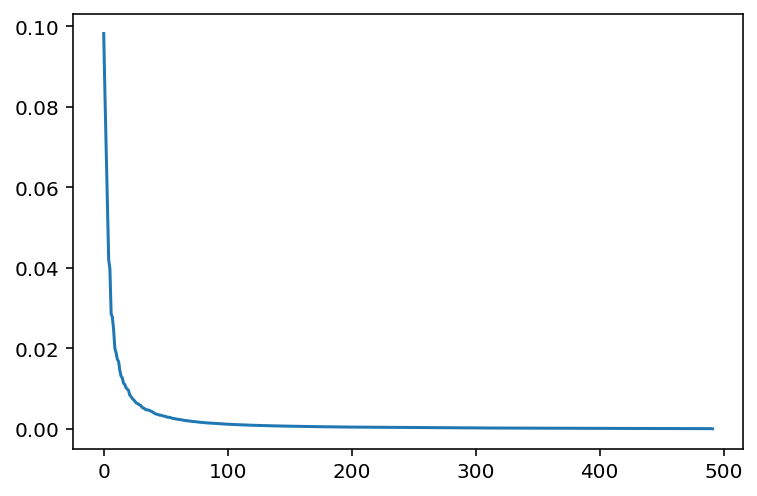

In [10]:
plt.plot(pca.explained_variance_ratio_)
pca.explained_variance_ratio_

In [11]:
alphas_list = np.logspace(-1, 5, 7)
final = []
np.random.seed(123)
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = np.asarray(data)[train_index]
        test = np.asarray(data)[test_index]
        train_x = train[:, 2:]
        train_y = train[:, 1]
        test_x = test[:, 2:]
        test_y = test[:, 1]
        pca = PCA(n_components=10)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model:', np.max(final))

R^2 of the best model: 0.4294727498027015


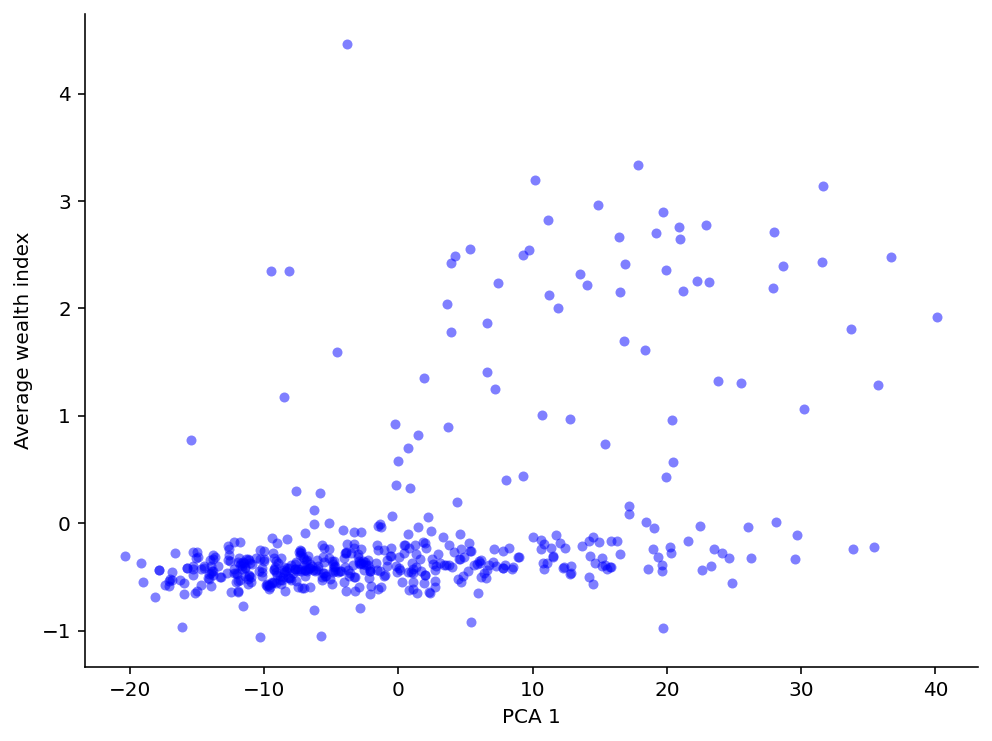

In [12]:
x = np.asarray(data)[:, 2:]
y = np.asarray(data)[:, 1]
pca = PCA(n_components=1)
pca.fit(x)
proj = pca.transform(x)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(proj[:,0], y, 'o', c='blue', markersize=5, markeredgecolor='none', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('Average wealth index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [13]:
trans_data.to_csv("processed/DHS_daytime.csv")